In [1]:
from operator import mul
import urllib2
import numpy as np
import tensorflow as tf


### For home robot

In [ ]:
im_shape = (480, 640, 3)
im_sz = reduce(mul, im_shape)
ROBOT_URL = 'http://localhost:8889/robot/%d/%d/%d/%d/%d/%d/'


def from_buffer(im_str):
    f1 = np.fromstring(im_str, dtype=np.uint8)
    return f1.reshape((480, 640, 3))    
    

def get_images():
    response=urllib2.urlopen('http://localhost:8889/camera')
    left = from_buffer(response.read(im_sz))
    right = from_buffer(response.read(im_sz))
    response.close()
    return left, right


episode_save_location = '/data/robotics/pick_episodes/'
pyrobo_path = "/home/karthik/code/pyrobo/network_models/"

### To be run for office robot


In [153]:
col_sz = (480, 640, 3)
dep_sz = (480, 640)
pnt_sz = (480, 640, 3)
cad_sz = (480, 640, 3)

col_dtype = np.uint8
dep_dtype = np.uint16
cad_dtype = np.uint8
pnt_dtype = np.float32

ROBOT_URL = 'http://robot.local:8888/robot/%d/%d/%d/%d/%d/%d/'

def from_buffer(im_str, sz, dtype_dat):
    f1 = np.fromstring(im_str, dtype=dtype_dat)
    return f1.reshape(sz)    

def get_images():
    response=urllib2.urlopen('http://robot.local:8888/camera')
    col = from_buffer(response.read(reduce(mul, col_sz)), col_sz, col_dtype)
    pnt = from_buffer(response.read(reduce(mul, pnt_sz)*4), pnt_sz, pnt_dtype)
    cad = from_buffer(response.read(reduce(mul, cad_sz)), cad_sz, cad_dtype)
    dep = from_buffer(response.read(reduce(mul, dep_sz)*2), dep_sz, dep_dtype)
    response.close()
    return col, pnt, cad, dep


episode_save_location = '/data/robotics/auto_episodic_data/'
pyrobo_path = '/Users/kk/code/pyrobo/'

In [149]:
%matplotlib inline
from matplotlib import pyplot as plt


/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:3: RuntimeWarning: divide by zero encountered in log
  app.launch_new_instance()


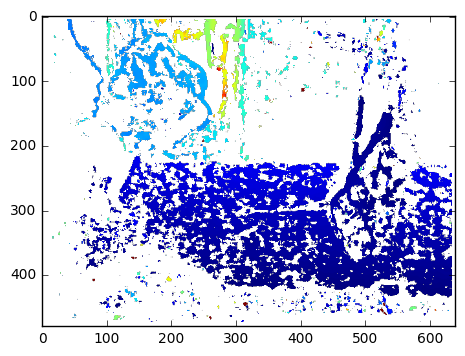

In [158]:
col, pnt, cad, dep = get_images()



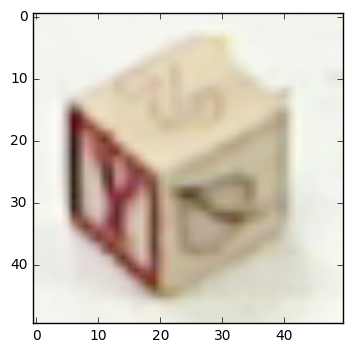

In [173]:
plt.imshow(col[332:382, 252:302])

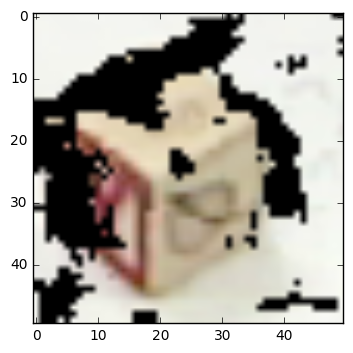

In [164]:
plt.imshow(cad[325:375, 300:350])

In [ ]:
import json
def get_ps3_out():
    response=urllib2.urlopen('http://localhost:8888/get')
    js, buttons = json.loads(''.join(response.readlines()))
    pressed_buttons = []
    for (button, state) in js.items():
        if state > 0.5:
            pressed_buttons.append(button)
        if state < -0.5 and button == '1':
            pressed_buttons.append('0')
            
    for (button, state) in buttons.items():
        if state > 0.5:
            pressed_buttons.append(button)
    return pressed_buttons

In [ ]:
get_ps3_out()

In [ ]:
motor_state = {0:1500, 1:1500, 2:1500, 3:1500, 4:1500, 5:1500}

import time
def move_robot():
    url = ROBOT_URL
    ms = [l[1] for l in sorted(motor_state.items(), key=lambda x: x[0])]
    call_url = url%tuple(ms)
    print call_url
    time.sleep(0.1)
    response = urllib2.urlopen(call_url)
    return response.readlines()

def update_state(motor_id, update_direction):
    motor_state[motor_id] = motor_state[motor_id] + 50*update_direction
    move_robot()
    
move_robot()    

In [ ]:
button_motor_map = {"0": [0, -1], "1": [0, +1], 
                    "2": [1, -1], "3": [1, +1],
                    "8": [2, -1], "10":[2, +1],
                    "9": [3, -1], "11":[3, +1],
                    "4": [4, -1], "6": [4, +1],
                    "14":[5, -1], "12":[5, +1]}


In [10]:
def _int64_feature(value):
    return tf.train.Feature(int64_list=tf.train.Int64List(value=value))

def _bytes_feature(value):
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def _float_feature(value):
    return tf.train.Feature(float_list=tf.train.FloatList(value=value))


# def save_state(writer, left_im, right_im, motor, direction, motor_state):
# l 

def save_record(writer):
    writer.close()

In [ ]:
episode = 0

In [ ]:
pi =  tf.python_io.TFRecordWriter(
"%s_%d.tfrecords"%(episode_save_location, episode))


try:
    while True:
        time.sleep(0.3)
        pressed = get_ps3_out()
        for press in pressed:
            motor, direction = button_motor_map.get(press,[None, None])
            if motor is None:
                continue
            left_im, right_im = get_images()
            
            save_state(pi, left_im, right_im, motor, direction, motor_state)
            update_state(motor, direction)
finally:
    episode+=1
    save_record(pi)
    motor_state = {0:1500, 1:1500, 2:1500, 3:1500, 4:1500, 5:1500}
    move_robot()
    print episode
    

In [ ]:

try:
    while True:
        time.sleep(0.3)
        pressed = get_ps3_out()
        for press in pressed:
            motor, direction = button_motor_map.get(press,[None, None])
            if motor is None:
                continue
#             left_im, right_im = get_images()
            
#             save_state(pi, left_im, right_im, motor, direction, motor_state)
            update_state(motor, direction)
finally:
    episode+=1
    save_record(pi)
    motor_state = {0:1500, 1:1500, 2:1500, 3:1500, 4:1500, 5:1500}
    move_robot()
    print episode


In [5]:
import sys
sys.path.append(pyrobo_path + '/network_models/')
from multicam_net import PurchasePredNet
net = PurchasePredNet()




In [7]:
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

In [ ]:
saver = tf.train.Saver()

saver.restore(sess, '/data/robotics/models/pick_episodes/25000_iters')

In [ ]:
import cv2
def rs(arr):
    return cv2.resize(arr, (224, 224)).reshape((1, 224, 224, 3))
left_im, right_im = [rs(x) for x in get_images()]

out_pred = sess.run(tf.nn.softmax(net.layers['out']), { net.left_img:left_im,
                                                    net.right_img: right_im} )

print(out_pred)
choice = np.argmax(out_pred)

motor = choice/2
direction = choice%2*2-1
print(motor, direction)
update_state(motor, direction)
# def extract_motor_direction(choice)

In [27]:
example_out = tf.train.Example(features=tf.train.Features(feature={
                'img_sz': _int32_feature((480, 640, 3))}))


AttributeError: 'module' object has no attribute 'Int32List'

In [22]:
img_sz = example_out.features.feature['img_sz'].int64_list.value

In [23]:
img_sz[0],img_sz[1], img_sz[2]

(480L, 640L, 3L)

In [26]:
def _int32_feature(value):
    return tf.train.Feature(int32_list=tf.train.Int32List(value=value))


In [28]:
from tftools import data as tfdata

In [31]:
p = np.uint8

In [42]:
%timeit col.tostring()

The slowest run took 4.37 times longer than the fastest. This could mean that an intermediate result is being cached.
10000 loops, best of 3: 95.3 µs per loop


In [38]:
%timeit col.tobytes()

10000 loops, best of 3: 91.5 µs per loop


In [39]:
import cPickle


In [43]:
%timeit cPickle.dumps(col.dtype)

100000 loops, best of 3: 9.6 µs per loop


In [46]:
cPickle.dumps(col.dtype)

"cnumpy\ndtype\np1\n(S'u1'\nI0\nI1\ntRp2\n(I3\nS'|'\nNNNI-1\nI-1\nI0\ntb."

In [48]:
%timeit cPickle.loads(cPickle.dumps(col.dtype))

100000 loops, best of 3: 18.2 µs per loop


### implementing spatial softmax

In [58]:
net.load('/data/models/VGG_imagenet.npy', sess, True)

In [64]:
import cv2
im = cv2.resize(col,(224,224))

In [65]:
im.shape

(224, 224, 3)

In [72]:
l_conv_2 = sess.run([net.layers['l_conv2_2']], {net.left_img:im.reshape(1,224,224,3)})

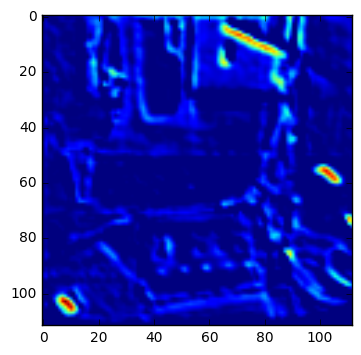

In [76]:
plt.imshow(l_conv_2[0][0, :, :, 0])

In [79]:
convout = l_conv_2[0][0, :, :, 0]

In [88]:
err = np.array([[1,0.5], [0.3, 0.7]])
tf.nn.softmax(err).eval()

array([[ 0.62245933,  0.37754067],
       [ 0.40131234,  0.59868766]])

In [83]:
tf.nn.softmax(net.layers['l_conv2_2'],dim=1).shape

TensorShape([Dimension(None), Dimension(112), Dimension(112), Dimension(128)])

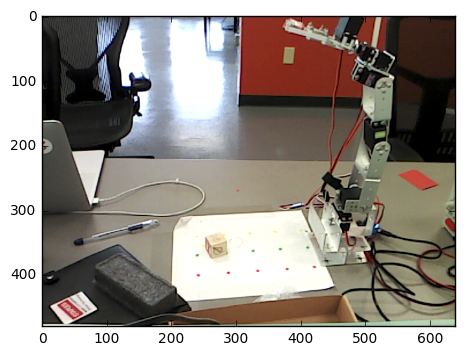

In [77]:
plt.imshow(col)

[<tf.Variable 'l_conv1_1/weights:0' shape=(3, 3, 3, 64) dtype=float32_ref>,
 <tf.Variable 'l_conv1_1/biases:0' shape=(64,) dtype=float32_ref>,
 <tf.Variable 'l_conv1_2/weights:0' shape=(3, 3, 64, 64) dtype=float32_ref>,
 <tf.Variable 'l_conv1_2/biases:0' shape=(64,) dtype=float32_ref>,
 <tf.Variable 'l_conv2_1/weights:0' shape=(3, 3, 64, 128) dtype=float32_ref>,
 <tf.Variable 'l_conv2_1/biases:0' shape=(128,) dtype=float32_ref>,
 <tf.Variable 'l_conv2_2/weights:0' shape=(3, 3, 128, 128) dtype=float32_ref>,
 <tf.Variable 'l_conv2_2/biases:0' shape=(128,) dtype=float32_ref>,
 <tf.Variable 'l_conv3_1/weights:0' shape=(3, 3, 128, 256) dtype=float32_ref>,
 <tf.Variable 'l_conv3_1/biases:0' shape=(256,) dtype=float32_ref>,
 <tf.Variable 'l_conv3_2/weights:0' shape=(3, 3, 256, 256) dtype=float32_ref>,
 <tf.Variable 'l_conv3_2/biases:0' shape=(256,) dtype=float32_ref>,
 <tf.Variable 'l_conv3_3/weights:0' shape=(3, 3, 256, 256) dtype=float32_ref>,
 <tf.Variable 'l_conv3_3/biases:0' shape=(256,)

In [132]:
num_rows = 112
num_cols = 112
x_map = np.empty([num_rows, num_cols], np.float32)
y_map = np.empty([num_rows, num_cols], np.float32)

for i in range(num_rows):
    for j in range(num_cols):
        x_map[i, j] = (i - num_rows / 2.0) / num_rows
        y_map[i, j] = (j - num_cols / 2.0) / num_cols

x_map = tf.convert_to_tensor(x_map)
y_map = tf.convert_to_tensor(y_map)

x_map = tf.reshape(x_map, [num_rows * num_cols])
y_map = tf.reshape(y_map, [num_rows * num_cols])

features = tf.reshape(tf.transpose(net.layers['l_conv2_2'], [0,3,1,2]),
                          [-1, 128, num_rows*num_cols])

softmax = tf.nn.softmax(features)

fp_x = tf.reduce_sum(tf.multiply(x_map, softmax), 2)
fp_y = tf.reduce_sum(tf.multiply(y_map, softmax), 2)

fp = tf.reshape(tf.concat(axis=1,values=[fp_x, fp_y]), [-1, 128*2])

In [146]:
def spatial_softmax(input,  name):
    """Softmax on spatial input"""
    batch_size, num_rows, num_cols, num_channels = [d.value for d in input.shape]
    if batch_size is None:
        batch_size = -1
    
    x_map = np.empty([num_rows, num_cols], np.float32)
    y_map = np.empty([num_rows, num_cols], np.float32)

    for i in range(num_rows):
        for j in range(num_cols):
            x_map[i, j] = (i - num_rows / 2.0) / num_rows
            y_map[i, j] = (j - num_cols / 2.0) / num_cols

    x_map = tf.convert_to_tensor(x_map)
    y_map = tf.convert_to_tensor(y_map)

    x_map = tf.reshape(x_map, [num_rows * num_cols])
    y_map = tf.reshape(y_map, [num_rows * num_cols])

    features = tf.reshape(tf.transpose(net.layers['l_conv2_2'], [0,3,1,2]),
                              [batch_size, num_channels, num_rows*num_cols])
    softmax = tf.nn.softmax(features)

    fp_x = tf.reduce_sum(tf.multiply(x_map, softmax), 2)
    fp_y = tf.reduce_sum(tf.multiply(y_map, softmax), 2)

    fp = tf.reshape(tf.concat(axis=1,values=[fp_x, fp_y]), [batch_size, num_channels*2], name=name)
    return fp

In [147]:
spatial_softmax(net.layers['l_conv2_2'], 'smax')

<tf.Tensor 'smax:0' shape=(?, 256) dtype=float32>

In [142]:
batch_size, num_rows, num_cols, num_channels =[x.value for x in net.layers['l_conv2_2'].shape]

In [143]:
batch_size

In [141]:
num_rows.value

112

In [112]:
xx = x_map.eval()
xx[-8:,-8:]

array([[ 0.42857143,  0.42857143,  0.42857143,  0.42857143,  0.42857143,
         0.42857143,  0.42857143,  0.42857143],
       [ 0.4375    ,  0.4375    ,  0.4375    ,  0.4375    ,  0.4375    ,
         0.4375    ,  0.4375    ,  0.4375    ],
       [ 0.44642857,  0.44642857,  0.44642857,  0.44642857,  0.44642857,
         0.44642857,  0.44642857,  0.44642857],
       [ 0.45535713,  0.45535713,  0.45535713,  0.45535713,  0.45535713,
         0.45535713,  0.45535713,  0.45535713],
       [ 0.4642857 ,  0.4642857 ,  0.4642857 ,  0.4642857 ,  0.4642857 ,
         0.4642857 ,  0.4642857 ,  0.4642857 ],
       [ 0.4732143 ,  0.4732143 ,  0.4732143 ,  0.4732143 ,  0.4732143 ,
         0.4732143 ,  0.4732143 ,  0.4732143 ],
       [ 0.48214287,  0.48214287,  0.48214287,  0.48214287,  0.48214287,
         0.48214287,  0.48214287,  0.48214287],
       [ 0.49107143,  0.49107143,  0.49107143,  0.49107143,  0.49107143,
         0.49107143,  0.49107143,  0.49107143]], dtype=float32)